In [ ]:
!pip install gradio

In [ ]:
!pip install transformers

In [ ]:
import gradio as gr
import torch
from torchaudio.sox_effects import apply_effects_file
from transformers import AutoFeatureExtractor, AutoModelForAudioXVector
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
EFFECTS = [
    ["remix", "-"],
    ["channels", "1"],
    ["rate", "16000"],
    ["gain", "-1.0"],
    ["silence", "1", "0.1", "0.1%", "-1", "0.1", "0.1%"],
    ["trim", "0", "10"],
]
THRESHOLD = 0.85
model_name = "microsoft/wavlm-base-plus-sv"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForAudioXVector.from_pretrained(model_name).to(device)
cosine_sim = torch.nn.CosineSimilarity(dim=-1)

Downloading:   0%|          | 0.00/57.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/215 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/386M [00:00<?, ?B/s]

In [ ]:
def is_acceptance(my_score):
  status = False
  if my_score >= 85:
    status = True
  return status

In [ ]:
def similarity_fn(path1, path2):
    if not (path1 and path2):
        return '<b style="color:red">ERROR: Please record audio for *both* speakers!</b>'
    wav1, _ = apply_effects_file(path1, EFFECTS)
    wav2, _ = apply_effects_file(path2, EFFECTS)
    print(wav1.shape, wav2.shape)
    input1 = feature_extractor(wav1.squeeze(0), return_tensors="pt", sampling_rate=16000).input_values.to(device)
    input2 = feature_extractor(wav2.squeeze(0), return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        emb1 = model(input1).embeddings
        emb2 = model(input2).embeddings
    emb1 = torch.nn.functional.normalize(emb1, dim=-1).cpu()
    emb2 = torch.nn.functional.normalize(emb2, dim=-1).cpu()
    similarity = cosine_sim(emb1, emb2).numpy()[0]
    if similarity >= THRESHOLD:
        #output = OUTPUT_OK.format(similarity * 100)
        output = is_acceptance(similarity * 100)
    else:
        #output = OUTPUT_FAIL.format(similarity * 100)
        output = is_acceptance(similarity * 100)
    return output


In [ ]:
def get_similarity_score(path1, path2):
    if not (path1 and path2):
        return '<b style="color:red">ERROR: Please record audio for *both* speakers!</b>'
    wav1, _ = apply_effects_file(path1, EFFECTS)
    wav2, _ = apply_effects_file(path2, EFFECTS)
    print(wav1.shape, wav2.shape)
    input1 = feature_extractor(wav1.squeeze(0), return_tensors="pt", sampling_rate=16000).input_values.to(device)
    input2 = feature_extractor(wav2.squeeze(0), return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        emb1 = model(input1).embeddings
        emb2 = model(input2).embeddings
    emb1 = torch.nn.functional.normalize(emb1, dim=-1).cpu()
    emb2 = torch.nn.functional.normalize(emb2, dim=-1).cpu()
    similarity = cosine_sim(emb1, emb2).numpy()[0]
    #output = similarity * 100
    output = similarity
    return output

In [ ]:
ls

drive/  sample_data/


create scores in file

In [ ]:

import os
labels = [] #true target or nontarget
predictions = [] #predict of WavLM
data_path ="/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/my_vox_data_v2"
scores = open(f"{data_path}/scores.txt", "a")
scores.truncate(0)
test_trials = open(f"test_trials_v2.txt", "a")
test_trials.truncate(0)

num_spk = 4
num_utt =6

for spk_id in range(1,num_spk+1):
    for utt_id in range(1,num_utt+1):
        cd_id = int((1+spk_id) / 2)
        path = os.path.abspath(f"{data_path}/spk{spk_id:03}/utt_{spk_id:03}F{utt_id:02}.wav")
        #ffmpeg_cmd = "ffmpeg -ss 0 -i {file_path} -t 60 -f wav -ac 1 -ar 8k -acodec pcm_s16le - |"
        #extended_filename = ffmpeg_cmd.format(file_path = path)
        path_cmd ="{file_path}"
        extended_filename = path_cmd.format(file_path = path)
        utterance_id = f"utt-{spk_id:03}F{utt_id:02}"
        speaker_id = f"spk-{spk_id:03}"
        #fmajor_wav_scp.write(f"{utterance_id} {extended_filename}\n")    
        #fmajor_utt2spk.write(f"{utterance_id} {speaker_id}\n")  
        if utt_id==1:
            #fenroll_wav_scp.write(f"{utterance_id} {extended_filename}\n") 
            #enroll_wavscp.write(f"{utterance_id} {extended_filename}\n")    
            #enroll_utt2spk.write(f"{utterance_id} {speaker_id}\n")
            path_enroll_utterance = extended_filename
        elif utt_id==2:
            #ftest_wav_scp.write(f"{utterance_id} {extended_filename}\n")  
            #test_wavscp.write(f"{utterance_id} {extended_filename}\n")   
            #test_utt2spk.write(f"{utterance_id} {speaker_id}\n")
            #path_test_utterance = extended_filename
            for spk_id_trials in range(1,num_spk+1):
                for utt_id_trials in range(2,num_utt+1):
                  path2 = os.path.abspath(f"{data_path}/spk{spk_id_trials:03}/utt_{spk_id_trials:03}F{utt_id_trials:02}.wav")
                  extended_filename2 = path_cmd.format(file_path = path2)
                  path_test_utterance = extended_filename2
                  utterance_id_trials = f"utt_{spk_id_trials:03}F{utt_id_trials:02}"
                  test_trials.write(f"{speaker_id} {utterance_id_trials} {'target' if spk_id_trials==spk_id else 'nontarget'}\n")
                  if spk_id_trials==spk_id:
                    labels.append(1)
                  else:
                    labels.append(0)
                  score =  get_similarity_score(path_enroll_utterance,path_test_utterance)
                  predictions.append(score)
                  scores.write(f"{speaker_id} {utterance_id_trials} {score}\n")

#enroll_utt2spk.close()
#test_utt2spk.close()
test_trials.close()
#test_wavscp.close()
#enroll_wavscp.close()
scores.close()

In [ ]:
#import os
labels = [] #true target or nontarget
predictions = [] #predict of WavLM
data_path ="/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/my_vox_data_v2"
scores = open(f"{data_path}/scores.txt", "a")
scores.truncate(0)
test_trials = open(f"{data_path}/test_trials_v2.txt", "a")
test_trials.truncate(0)

num_spk = 4
num_utt =6

for spk_id in range(1,num_spk+1):
    for utt_id in range(1,num_utt+1):
        #cd_id = int((1+spk_id) / 2)
        path = os.path.abspath(f"{data_path}/spk{spk_id:03}/utt_{spk_id:03}F{utt_id:02}.wav")
        path_cmd ="{file_path}"
        extended_filename = path_cmd.format(file_path = path)
        utterance_id = f"utt-{spk_id:03}F{utt_id:02}"
        speaker_id = f"spk-{spk_id:03}"  
        if utt_id==1:
            path_enroll_utterance = extended_filename
        elif utt_id==2:
            for spk_id_trials in range(1,num_spk+1):
                for utt_id_trials in range(2,num_utt+1):
                  path2 = os.path.abspath(f"{data_path}/spk{spk_id_trials:03}/utt_{spk_id_trials:03}F{utt_id_trials:02}.wav")
                  extended_filename2 = path_cmd.format(file_path = path2)
                  path_test_utterance = extended_filename2
                  utterance_id_trials = f"utt_{spk_id_trials:03}F{utt_id_trials:02}"
                  test_trials.write(f"{speaker_id} {utterance_id_trials} {'target' if spk_id_trials==spk_id else 'nontarget'}\n")
                  if spk_id_trials==spk_id:
                    labels.append(1)
                  else:
                    labels.append(0)
                  score =  get_similarity_score(path_enroll_utterance,path_test_utterance)
                  predictions.append(score)
                  scores.write(f"{speaker_id} {utterance_id_trials} {score}\n")

test_trials.close()
scores.close()

torch.Size([1, 110542]) torch.Size([1, 67572])
torch.Size([1, 110542]) torch.Size([1, 160000])
torch.Size([1, 110542]) torch.Size([1, 76797])
torch.Size([1, 110542]) torch.Size([1, 160000])
torch.Size([1, 110542]) torch.Size([1, 78844])
torch.Size([1, 110542]) torch.Size([1, 75747])
torch.Size([1, 110542]) torch.Size([1, 160000])
torch.Size([1, 110542]) torch.Size([1, 160000])
torch.Size([1, 110542]) torch.Size([1, 75759])
torch.Size([1, 110542]) torch.Size([1, 160000])
torch.Size([1, 110542]) torch.Size([1, 69629])
torch.Size([1, 110542]) torch.Size([1, 66560])
torch.Size([1, 110542]) torch.Size([1, 102386])
torch.Size([1, 110542]) torch.Size([1, 71679])
torch.Size([1, 110542]) torch.Size([1, 74747])
torch.Size([1, 110542]) torch.Size([1, 132096])
torch.Size([1, 110542]) torch.Size([1, 64512])
torch.Size([1, 110542]) torch.Size([1, 106496])
torch.Size([1, 110542]) torch.Size([1, 131071])
torch.Size([1, 110542]) torch.Size([1, 70656])
torch.Size([1, 137215]) torch.Size([1, 67572])
torc

create wav.scp file

In [ ]:

# utt2spk
import os
data_path ="/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/my_vox_data_v2"
#os.chdir('spk004')
enroll_wavscp = open(f"{data_path}/enroll_wavscp_v1.txt", "a")
enroll_wavscp.truncate(0)
test_wavscp = open(f"{data_path}/test_wavscp_v1.txt", "a")
test_wavscp.truncate(0)
#enroll_utt2spk = open(f"enroll_utt2spk.txt", "a")
#enroll_utt2spk.truncate(0)
#test_utt2spk = open(f"test_utt2spk.txt", "a")
#test_utt2spk.truncate(0)
#test_trials = open(f"test_trials.txt", "a")
#test_trials.truncate(0)

num_utt =6
num_spk = 4
for spk_id in range(1,num_spk+1):
    for utt_id in range(1,num_utt+1):
        cd_id = int((1+spk_id) / 2)
        path = os.path.abspath(f"{data_path}/{spk_id:03}/{spk_id:03}F{utt_id:02}.WAV")
        #ffmpeg_cmd = "ffmpeg -ss 0 -i {file_path} -t 60 -f wav -ac 1 -ar 8k -acodec pcm_s16le - |"
        #extended_filename = ffmpeg_cmd.format(file_path = path)
        path_cmd ="{file_path}"
        extended_filename = path_cmd.format(file_path = path)
        utterance_id = f"utt-{spk_id:03}F{utt_id:02}"
        speaker_id = f"spk-{spk_id:03}"
        #fmajor_wav_scp.write(f"{utterance_id} {extended_filename}\n")    
        #fmajor_utt2spk.write(f"{utterance_id} {speaker_id}\n")  
        if utt_id==1:
            #fenroll_wav_scp.write(f"{utterance_id} {extended_filename}\n") 
            enroll_wavscp.write(f"{utterance_id} {extended_filename}\n")    
            #enroll_utt2spk.write(f"{utterance_id} {speaker_id}\n")  
        else:
            #ftest_wav_scp.write(f"{utterance_id} {extended_filename}\n")  
            test_wavscp.write(f"{utterance_id} {extended_filename}\n")   
            #test_utt2spk.write(f"{utterance_id} {speaker_id}\n")
            #for spk_id_trials in range(1,num_spk+1):
               # for utt_id_trials in range(2,num_utt+1):
                   # utterance_id_trials = f"utt-{spk_id_trials:03}F{utt_id_trials:02}"
                   # test_trials.write(f"{speaker_id} {utterance_id_trials} {'target' if spk_id_trials==spk_id else 'nontarget'}\n")


#enroll_utt2spk.close()
#test_utt2spk.close()
#test_trials.close()
test_wavscp.close()
enroll_wavscp.close()




create scores in file

In [ ]:
print(get_similarity_score("/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/my_vox_data_v2/spk001/utt_001F01.wav","/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/my_vox_data_v2/spk002/utt_002F02.wav"))

torch.Size([1, 110542]) torch.Size([1, 75747])
0.8904583


In [ ]:
print(labels)

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [ ]:
print(predictions)

[0.98836035, 0.98402464, 0.99020565, 0.9879558, 0.97803056, 0.8904583, 0.87461686, 0.7997459, 0.8075437, 0.85189164, 0.518013, 0.3902642, 0.44134843, 0.40447345, 0.4193719, 0.86757237, 0.8458769, 0.8568024, 0.8359634, 0.77351636, 0.884343, 0.90785456, 0.8918041, 0.89818525, 0.8738456, 0.97500855, 0.9813192, 0.95017076, 0.94611245, 0.9750847, 0.6125076, 0.5566407, 0.58357185, 0.55036163, 0.5601927, 0.96368325, 0.9706617, 0.96392244, 0.96138924, 0.8684856, 0.43684113, 0.48994872, 0.4227484, 0.4200299, 0.5164896, 0.5808738, 0.6324014, 0.6135862, 0.6183951, 0.59164584, 0.978427, 0.9760932, 0.9780202, 0.9815458, 0.98670083, 0.5925865, 0.6523986, 0.6582704, 0.6711916, 0.6509311, 0.85218495, 0.8812409, 0.85321254, 0.85029715, 0.8414747, 0.956638, 0.9752766, 0.94073755, 0.934567, 0.9666983, 0.6612425, 0.6167853, 0.6431539, 0.6077437, 0.6193458, 0.9656308, 0.9643094, 0.97714305, 0.97644967, 0.9042121]


python-compute-eer
https://github.com/YuanGongND/python-compute-eer


In [ ]:
import numpy as np
import sklearn.metrics

"""
Python compute equal error rate (eer)
ONLY tested on binary classification

:param label: ground-truth label, should be a 1-d list or np.array, each element represents the ground-truth label of one sample
:param pred: model prediction, should be a 1-d list or np.array, each element represents the model prediction of one sample
:param positive_label: the class that is viewed as positive class when computing EER
:return: equal error rate (EER)
"""
def compute_eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    #fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred, positive_label)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred)
    fnr = 1 - tpr

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2
    return eer

In [ ]:
#from compute_eer import compute_eer
label = [1, 1, 0, 0, 1]
prediction = [0.3, 0.1, 0.4, 0.8, 0.9]
eer = compute_eer(label, prediction)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.833


compute my eer

In [ ]:
eer = compute_eer(labels, predictions)
print('The equal error rate is {:.3f}'.format(eer))

The equal error rate is 0.133


#plot far,fpr,eer

In [ ]:
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
"""
plot fpr,tpr,eer
"""
def plot_eer(label, pred, positive_label=1):
    # all fpr, tpr, fnr, fnr, threshold are lists (in the format of np.array)
    #fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred, positive_label)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(label, pred)

    far = np.array(fpr)
    print('FAR: ',far)
    print('-----------------------------------------------------------')

    fnr = 1 - tpr

    frr = np.array(fnr)
    print('FRR: ',frr)
    print('-----------------------------------------------------------')

    # the threshold of fnr == fpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]

    # theoretically eer from fpr and eer from fnr should be identical but they can be slightly differ in reality
    eer_1 = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    eer_2 = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    # return the mean of eer from fpr and from fnr
    eer = (eer_1 + eer_2) / 2

    plt.plot(threshold,frr,'--b')
    plt.xlabel('threshold')
    plt.title('FRR')
    plt.axis([0.0, 1.0, 0, 1.0])
    #plt.axis([0.0, 1.0, 0.0, 100.0])
    plt.show()

    plt.plot(threshold,far,'--r')
    plt.xlabel('threshold')
    plt.title('FAR')
    plt.axis([0.0, 1.0, 0.0, 1.0])
    #plt.axis([0.0, 1.0, 0.0, 100.0])
    plt.show()

    return eer

#eer_scikit_learn

FAR:  [0.         0.         0.         0.01666667 0.01666667 0.05
 0.05       0.11666667 0.11666667 0.16666667 0.16666667 1.        ]
-----------------------------------------------------------
FRR:  [1.   0.95 0.35 0.35 0.25 0.25 0.15 0.15 0.05 0.05 0.   0.  ]
-----------------------------------------------------------


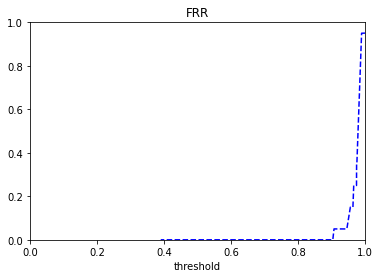

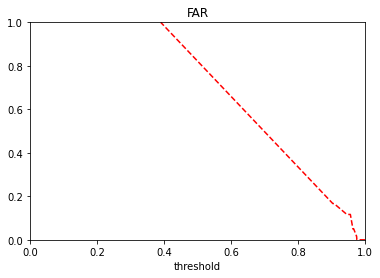

The equal error rate is 0.133


In [ ]:
eer = plot_eer(labels, predictions)
print('The equal error rate is {:.3f}'.format(eer))

#Eval_metrics :
https://github.com/Wenhao-Yang/SpeakerVerifiaction-pytorch/blob/master/Eval/eval_metrics.py


In [ ]:
import os
from operator import itemgetter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy.stats import norm

In [ ]:
def calculate_roc(thresholds, distances, labels):

    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)

    tprs = np.zeros((nrof_thresholds))
    fprs = np.zeros((nrof_thresholds))
    acc_train = np.zeros((nrof_thresholds))
    accuracy = 0.0

    indices = np.arange(nrof_pairs)

    # Find the best threshold for the fold

    for threshold_idx, threshold in enumerate(thresholds):
        tprs[threshold_idx], fprs[threshold_idx], acc_train[threshold_idx] = calculate_accuracy(threshold, distances, labels)
    best_threshold_index = np.argmax(acc_train)

    return tprs[best_threshold_index], fprs[best_threshold_index], acc_train[best_threshold_index]

In [ ]:
#change dist.size
def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    #fnr = 0 if (tp+fn==0) else float(fn) / float(tp+fn)

    #acc = float(tp+tn)/dist.size
    acc = float(tp+tn)/len(dist)
    return tpr, fpr, acc

In [ ]:
def calculate_eer(thresholds, distances, labels):

    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)

    tprs = np.zeros((nrof_thresholds))
    fprs = np.zeros((nrof_thresholds))
    fnrs = np.zeros((nrof_thresholds))
    acc_train = np.zeros((nrof_thresholds))
    accuracy = 0.0

    indices = np.arange(nrof_pairs)

    # Find the threshold where fnr=fpr for the fold
    # Todo: And the highest accuracy??
    eer_index = 0
    fpr_fnr = 1.0
    for threshold_idx, threshold in enumerate(thresholds):
        tprs[threshold_idx], fprs[threshold_idx], fnrs[threshold_idx], acc_train[threshold_idx] = calculate_eer_accuracy(threshold, distances, labels)
        if np.abs(fprs[threshold_idx]-fnrs[threshold_idx])<fpr_fnr:
            eer_index = threshold_idx
            fpr_fnr = np.abs(fprs[threshold_idx]-fnrs[threshold_idx])

    #print("Threshold for the eer is {}.".format(thresholds[eer_index]))
    return  fnrs[eer_index], acc_train[eer_index]

In [ ]:
def calculate_eer_accuracy(threshold, dist, actual_issame):
    predict_issame = np.greater(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp + fn == 0) else float(tp) / float(tp + fn)
    fpr = 0 if (fp + tn == 0) else float(fp) / float(fp + tn)

    fnr = 0 if (tp + fn == 0) else float(fn) / float(tp + fn)

    acc = float(tp + tn) / dist.size
    return tpr, fpr, fnr, acc

In [ ]:
def calculate_val(thresholds, distances, labels, far_target=0.1):
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)

    indices = np.arange(nrof_pairs)

    # Find the threshold that gives FAR = far_target
    far_train = np.zeros(nrof_thresholds)

    for threshold_idx, threshold in enumerate(thresholds):
        _, far_train[threshold_idx] = calculate_val_far(threshold, distances, labels)
    if np.max(far_train)>=far_target:
        f = interpolate.interp1d(far_train, thresholds, kind='slinear')
        threshold = f(far_target)
    else:
        threshold = 0.0

    val, far = calculate_val_far(threshold, distances, labels)

    return val, far

In [ ]:
def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    if n_diff == 0:
        n_diff = 1
    if n_same == 0:
        return 0,0
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far

In [ ]:
def evaluate_kaldi_eer(distances, labels, cos=True, re_thre=False):
    """
    The distance score should be larger when two samples are more similar.
    :param distances:
    :param labels:
    :param cos:
    :return:
    """
    # split the target and non-target distance array
    target = []
    non_target = []
    new_distances = []

    for (distance, label) in zip(distances, labels):
        if not cos:
            distance = -distance

        new_distances.append(-distance)
        if label:
            target.append(distance)
        else:
            non_target.append(distance)

    new_distances = np.array(new_distances)
    target = np.sort(target)
    non_target = np.sort(non_target)

    target_size = target.size
    nontarget_size = non_target.size
    # pdb.set_trace()
    target_position = 0
    while target_position + 1 < target_size:
        # for target_position in range(target_size):
        nontarget_n = nontarget_size * target_position * 1.0 / target_size
        nontarget_position = int(nontarget_size - 1 - nontarget_n)

        if (nontarget_position < 0):
            nontarget_position = 0
        # The exceptions from non targets are samples where cosine score is > the target score
        # if (non_target[nontarget_position] <= target[target_position]):
        #     break
        if (non_target[nontarget_position] < target[target_position]):
            # print('target[{}]={} is < non_target[{}]={}.'.format(target_position, target[target_position], nontarget_position, non_target[nontarget_position]))
            break
        target_position += 1

    eer_threshold = target[target_position]
    eer = target_position * 1.0 / target_size

    # max_threshold = np.max(distances)
    # thresholds = np.arange(0, max_threshold, 0.001)
    thresholds = np.sort(np.unique(target))
    tpr, fpr, best_accuracy = calculate_roc(thresholds, new_distances, labels)

    # return eer threshold.
    if re_thre:
        return eer, eer_threshold, best_accuracy
    return eer, best_accuracy

In [ ]:
def evaluate(distances, labels):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 30, 0.01)
    tpr, fpr, accuracy = calculate_roc(thresholds, distances,
        labels)

    thresholds = np.arange(0, 30, 0.001)
    val,  far = calculate_val(thresholds, distances,
        labels, 1e-3)

    return tpr, fpr, accuracy, val,  far

In [ ]:
# Creates a list of false-negative rates, a list of false-positive rates
# and a list of decision thresholds that give those error-rates.
def ComputeErrorRates(scores, labels):
    # Sort the scores from smallest to largest, and also get the corresponding
    # indexes of the sorted scores.  We will treat the sorted scores as the
    # thresholds at which the the error-rates are evaluated.
    sorted_indexes, thresholds = zip(*sorted([(index, threshold) for index, threshold in enumerate(scores)],
                                             key=itemgetter(1)))
    sorted_labels = []
    labels = [int(labels[i]) for i in sorted_indexes]
    fnrs = []  # 小于阈值的正例数目
    fprs = []  # 小于阈值的反例数目

    # At the end of this loop, fnrs[i] is the number of errors made by
    # incorrectly rejecting scores less than thresholds[i]. And, fprs[i]
    # is the total number of times that we have correctly accepted scores
    # greater than thresholds[i].
    for i in range(0, len(labels)):
        if i == 0:
            fnrs.append(labels[i])
            fprs.append(1 - labels[i])
        else:
            fnrs.append(fnrs[i - 1] + labels[i])
            fprs.append(fprs[i - 1] + 1 - labels[i])

    fnrs_norm = sum(labels)  # 样本中的正例数目
    fprs_norm = len(labels) - fnrs_norm  # 样本中的反例数目

    # Now divide by the total number of false negative errors to obtain the false positive rates across all thresholds.
    # 小于阈值而被认为是反例的正例在所有正例的样本比重
    fnrs = [x / float(fnrs_norm) for x in fnrs]

    # Divide by the total number of corret positives to get the true positive rate.
    # Subtract these quantities from 1 to get the false positive rates.
    # 大于阈值而被认为是正例的反例在所有反例中的样本比重

    fprs = [1 - x / float(fprs_norm) for x in fprs]

    return fnrs, fprs, thresholds

In [ ]:
# Computes the minimum of the detection cost function.  The comments refer to
# equations in Section 3 of the NIST 2016 Speaker Recognition Evaluation Plan.
def ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa):
    """
    :param fnrs: 正例的错误拒绝率
    :param fprs: 反例的错误接受率
    :param thresholds: 判断的阈值
    :param p_target: a priori probability of the specified target speaker
    :param c_miss: cost of a missed detection 遗漏正例的损失值
    :param c_fa: cost of a spurious detection 错误接受的损失值
    :return:
    """
    min_c_det = float("inf")
    min_c_det_threshold = thresholds[0]
    for i in range(0, len(fnrs)):
        # See Equation (2).  it is a weighted sum of false negative
        # and false positive errors.
        c_det = c_miss * fnrs[i] * p_target + c_fa * fprs[i] * (1 - p_target)
        if c_det < min_c_det:
            # 找到最小的det值
            min_c_det = c_det
            min_c_det_threshold = thresholds[i]
    # See Equations (3) and (4).  Now we normalize the cost.
    c_def = min(c_miss * p_target, c_fa * (1 - p_target))
    min_dcf = min_c_det / c_def
    return min_dcf, min_c_det_threshold

In [ ]:
def evaluate_kaldi_mindcf(scores, labels, return_threshold=False):
    c_miss = 1
    c_fa = 1
    labels = [int(x) for x in labels]
    fnrs, fprs, thresholds = ComputeErrorRates(scores, labels)

    p_target = 0.01
    mindcf_01, threshold_01 = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

    p_target = 0.001
    mindcf_001, threshold_001 = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

    if return_threshold:
        return (mindcf_01, threshold_01, mindcf_001, threshold_001)

    return mindcf_01, mindcf_001

In [ ]:
tpr, fpr, accuracy, val,  far = evaluate(labels, predictions)
print('The tpr is {:.3f}'.format(tpr))
print('The fpr is {:.3f}'.format(fpr))
print('The accuracy is {:.3f}'.format(accuracy))
print('The val is {:.3f}'.format(val))
print('The far is {:.3f}'.format(far))

The tpr is 1.000
The fpr is 0.000
The accuracy is 1.000
The val is 0.000
The far is 0.000


In [ ]:
ComputeErrorRates(labels, predictions)

#evaluate_kaldi_eer

In [ ]:
eer1, best_accuracy1 = evaluate_kaldi_eer(predictions, labels, cos=True, re_thre=False)
print('The eer is {:.3f}'.format(eer1))
print('The best_accuracy is {:.3f}'.format(best_accuracy1))

The eer is 0.150
The best_accuracy is 0.250


#end of this code

read labels and predictions

In [ ]:

import os
data_path ="/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/my_vox_data_v2"
scores = open(f"{data_path}/scores.txt", "r")
scores.truncate(0)
test_trials = open(f"test_trials.txt", "a")
test_trials.truncate(0)

In [ ]:
print(similarity_fn('/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/download.wav','/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/download.wav'))

torch.Size([1, 45820]) torch.Size([1, 45820])
100.0


In [ ]:
print(similarity_fn('/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/download.wav','/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/download2.wav'))

torch.Size([1, 45820]) torch.Size([1, 43206])
74.45922493934631


In [ ]:
print(similarity_fn('/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/mehdi-v1-1.wav','/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/mehdi-v1-2.wav'))

torch.Size([1, 44954]) torch.Size([1, 54551])
97.22150564193726


In [ ]:
print(similarity_fn('/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/mehdi-v1-1.wav','/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/mehdi-v1-2.wav'))

torch.Size([1, 44954]) torch.Size([1, 54551])
True


In [ ]:
print(similarity_fn('/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/mehdi1.wav','/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/mehdi2.wav'))

torch.Size([1, 51345]) torch.Size([1, 47248])
True


In [ ]:
print(similarity_fn('/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/download.wav','/content/drive/MyDrive/Proposal_Files/Implementation/wavlm-app/mehdi2.wav'))

torch.Size([1, 45820]) torch.Size([1, 47248])
False


In [ ]:
inputs = [
    gr.inputs.Audio(source="microphone", type="filepath", optional=True, label="Speaker #1"),
    gr.inputs.Audio(source="microphone", type="filepath", optional=True, label="Speaker #2"),
]
output = gr.outputs.HTML(label="")